# Imports

In [24]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
import keras.ops
from keras import Loss

# Train on single vehicle dynamics

## Constant coefficient car

In [6]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m 
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
    
        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""
        
        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)
        

        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)
        
        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)
        
        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])
    

## Generate synthetic data

In [128]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
x0 = (0, 20/3.6) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

#DEFINE U
t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp = np.array([0.5, 1, -0.2, 0.35, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

## Simulate measurements (add noise)

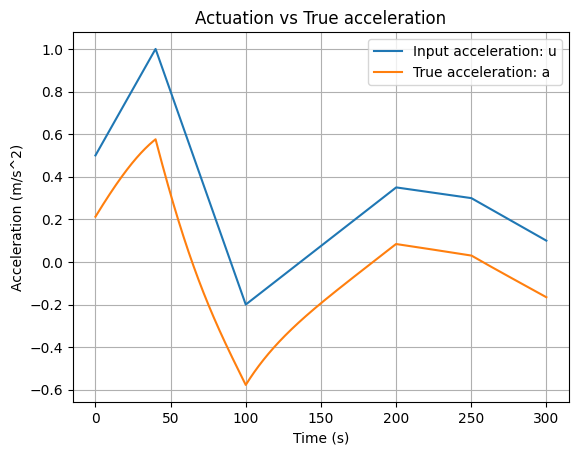

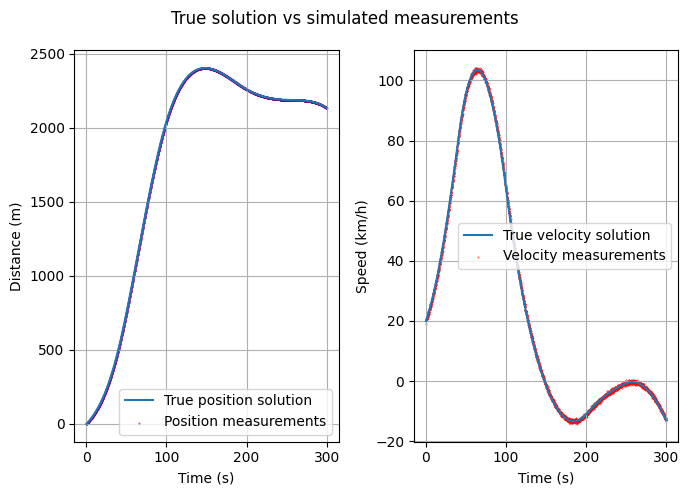

In [129]:
variance = 0.1

x_true = np.array(car.history["x"]).reshape(-1, 1)
v_true = np.array(car.history["v"]).reshape(-1, 1)
X_true = np.hstack((x_true, v_true))
X_noise = X_true + np.random.normal(0, variance, size=X_true.shape)

plt.plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
plt.plot(t, car.history["a"], label="True acceleration: a")
plt.title("Actuation vs True acceleration")
plt.grid()
plt.legend();
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
fig = plt.figure(figsize=(7,5))
fig.suptitle("True solution vs simulated measurements")
ax=fig.subplots(1,2)
ax[0].plot(t, X_true[:, 0], label="True position solution")
ax[0].scatter(t, X_noise[:, 0], label="Position measurements", s=0.1, color="purple")
ax[0].set_ylabel("Distance (m)")
ax[1].plot(t, X_true[:, 1]*3.6, label="True velocity solution")
ax[1].scatter(t, X_noise[:, 1]*3.6, label="Velocity measurements", s=0.1, color="red")
ax[1].set_ylabel("Speed (km/h)")
for i in range(len(ax)):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
fig.tight_layout()

## Forward Problem

In [130]:
#helper functions
def z_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std, mean, std
 
def comparison_plot(t, true_data: np.ndarray, meas_data: np.ndarray, pred_data: np.ndarray, suptitle: str, collocation_pts=[]):
    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12,8))
    plt.suptitle(suptitle)
    # Plot for position:
    plt.subplot(1,2,1)
    plt.plot(t, true_data[:, 0], label="True Position", linewidth=2)
    plt.plot(t, pred_data[:, 0], '--', label="Predicted Position", linewidth=2)
    plt.scatter(t, meas_data[:, 0], label="Measured position points", s=1, color="red")
    plt.scatter(collocation_pts, np.zeros_like(collocation_pts), label="Collocation points",  marker="x", c="green")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1,2,2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2)
    plt.plot(t, pred_data[:, 1]*3.6, '--', label="Predicted Velocity", linewidth=2)
    plt.scatter(t, meas_data[:, 1]*3.6, label="Measured velocity points", s=1, color="red")
    plt.scatter(collocation_pts, np.zeros_like(collocation_pts), label="Collocation points", marker="x", c="green")

    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, n_epochs):
    loss = history["loss"]
    val_loss = history["val_loss"]
    plt.plot(range(1,n_epochs+1), loss, label="Training Loss")
    plt.plot(range(1,n_epochs+1), val_loss, label="Validation Loss (against measurements)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

# Prepping data

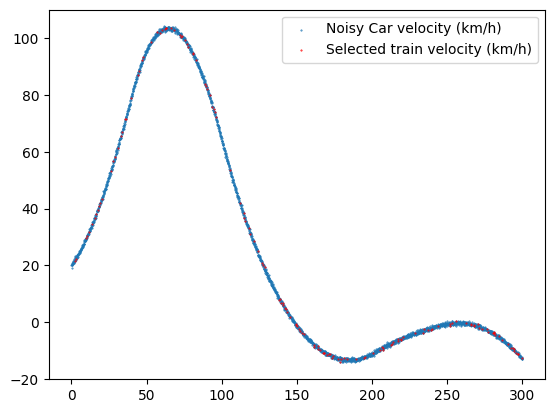

In [133]:
# prepping the data
train_ratio = .05
X_train, X_test, t_train, t_test = train_test_split(X_noise, t, train_size=train_ratio, random_state=31)
#print(X_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(t, t_train)
X_mask = X_noise.copy()
X_mask[~mask] = np.nan
plt.scatter(t, X_noise[:, 1] * 3.6, label="Noisy Car velocity (km/h)", s=.2)
plt.scatter(t, X_mask[:, 1] * 3.6, label="Selected train velocity (km/h)", s=.2, color="red")
plt.legend()
plt.show()

#Normalize data -> normal probably is a good dist
# if we dont do this, position contributes more to the loss, due to the sheer inbalance of scale
X_train_norm, mean_X_train, std_X_train = z_normalize(X_train)
X_test_norm, _, _ = z_normalize(X_test)
X_true_norm, _, _= z_normalize(X_true)
# feature normalization -> make sure 
t_train_norm = t_train/t_end
t_test_norm = t_test/t_end
t_norm = t/t_end


### PUNN-only

In [134]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 250
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
loss = "mse"
#------

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(1, ))) #input: t
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
history_punn_fwd = punn_model.fit(x=t_train_norm, y=X_train_norm, validation_data=(t_norm,X_true_norm), 
                                  batch_size=16, epochs=epochs, verbose=True)
#considering ground truth validation loss

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 0.9658 - val_loss: 0.7853
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.7754 - val_loss: 0.6633
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.6746 - val_loss: 0.5378
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.5168 - val_loss: 0.4405
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.4404 - val_loss: 0.4131
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.4289 - val_loss: 0.4304
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.4501 - val_loss: 0.4085
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.4066 - val_loss: 0.4073
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.4336 - val_loss: 0.4073
Epoch 10/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.4053 - val_loss: 0.4048
Epoch 11/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.4031 - val_loss: 0.3997
Epoch 12/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/s

In [121]:
punn_model.save("punn_model_forward.h5")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


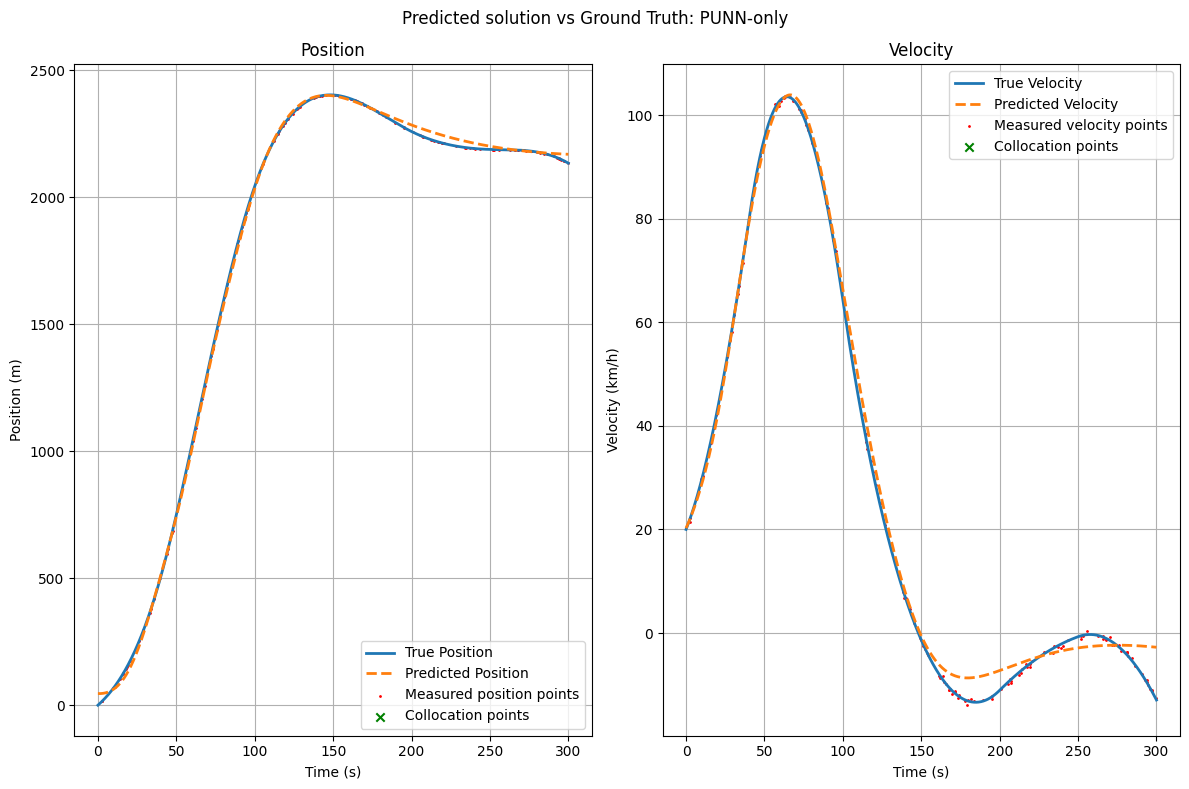

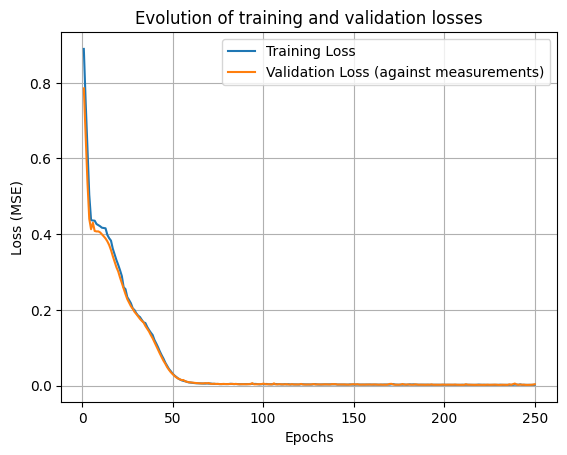

In [ ]:
#punn_model = load_model("punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
predictions_norm = punn_model.predict(t_norm)   #predictions shape will be (3000, 2)
predictions = predictions_norm * std_X_train + mean_X_train 

comparison_plot(t, X_true, X_mask, predictions, "Predicted solution vs Ground Truth: PUNN-only")
loss_plot(history_punn_fwd.history, epochs)


### PINN

#### Combined Loss

In [ ]:
collocation_size = len(t_train) #same number as training for now
t_c = np.linspace(start=0, stop=t_end, num=collocation_size)#collocation points -> uniform sampling for now
t_c_norm = t_c/t_end

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, u: np.ndarray, t_c, t_end, std_X_train, mean_X_train, alpha_d=0.5, alpha_p=0.5):
        super().__init__()
        self.car = car
        self.model = model
        self.u = u #at t_c
        self.t_c = tf.constant(t_c, dtype=tf.float32)
        self.alpha_d = alpha_d  # data loss weight
        self.alpha_p = alpha_p  # physics loss weight
        self.std_X_train = std_X_train
        self.mean_X_train = mean_X_train
        self.t_end = t_end

    def data_loss(self, y_true, y_pred):
        sqr_diff = keras.ops.square(y_true - y_pred)
        return keras.ops.mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car
        model = self.model
        u = self.u
        t_c = self.t_c

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t_c) #record gradients for all collocation points (normalized)
            #we need the model because collocation points might not be training points!
            predictions = model(t_c) * self.std_X_train + self.mean_X_train #DENORMALIZE
            x_pred = predictions[:, 0] 
            v_pred = predictions[:, 1]

        dx_dt = tape.gradient(x_pred, t_c) * self.t_end #DO NOT FORGET DENORMALIZATION, t_c is normalized
        dv_dt = tape.gradient(v_pred, t_c) * self.t_end

        Fr = (car.c0 + car.c1*v_pred)*(car.m*g*np.cos(car.road_grade))
        Fa = (car.p*car.Cd*car.Af*v_pred**2)/2
        Fg = car.m*g*np.sin(car.road_grade)

        res_x, res_v = dx_dt-v_pred, car.m * dv_dt - (u - Fr - Fa - Fg)
        res = keras.ops.stack([res_x, res_v], axis=-1)
        sqr_diff = keras.ops.square(res)
        return keras.ops.mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()

        return self.alpha_d*data_loss + self.alpha_p*pde_loss


TypeError: linspace() got an unexpected keyword argument 'size'

#### Training

In [150]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 250
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
alpha_d = 0.2
alpha_p = 1-alpha_d
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(1, ))) #input: t
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
loss = CombinedLoss(car, pinn_model, u(t_c), t_c_norm, std_X_train=std_X_train, 
                    mean_X_train=mean_X_train, t_end=t_end, alpha_d=alpha_d, alpha_p=alpha_p)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()
history_pinn_fwd = pinn_model.fit(x=t_train_norm, y=X_train_norm, validation_data=(t_norm,X_true_norm), 
                                  batch_size=16, epochs=epochs, verbose=True)
#considering measurements validation loss, not ground truth

Epoch 1/250
 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 206230061056.0000

2025-03-17 19:38:27.085447: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 8 bytes spill stores, 8 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - loss: 143373598720.0000 - val_loss: 59306725376.0000
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 36306837504.0000 - val_loss: 10950411264.0000
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 6494282240.0000 - val_loss: 607502464.0000
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 2681358080.0000 - val_loss: 2854608640.0000
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1612618496.0000 - val_loss: 99668200.0000
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 282675712.0000 - val_loss: 387624544.0000
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 234086864.0000 - val_loss: 19873852.0000
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 57819528.0000 - val_loss: 55010704.0000
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 34978104.0000 - val_loss: 27423734.0000
Epoch 10/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 22948624.0000 -

In [151]:
pinn_model.save("pinn_model_forward.h5")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


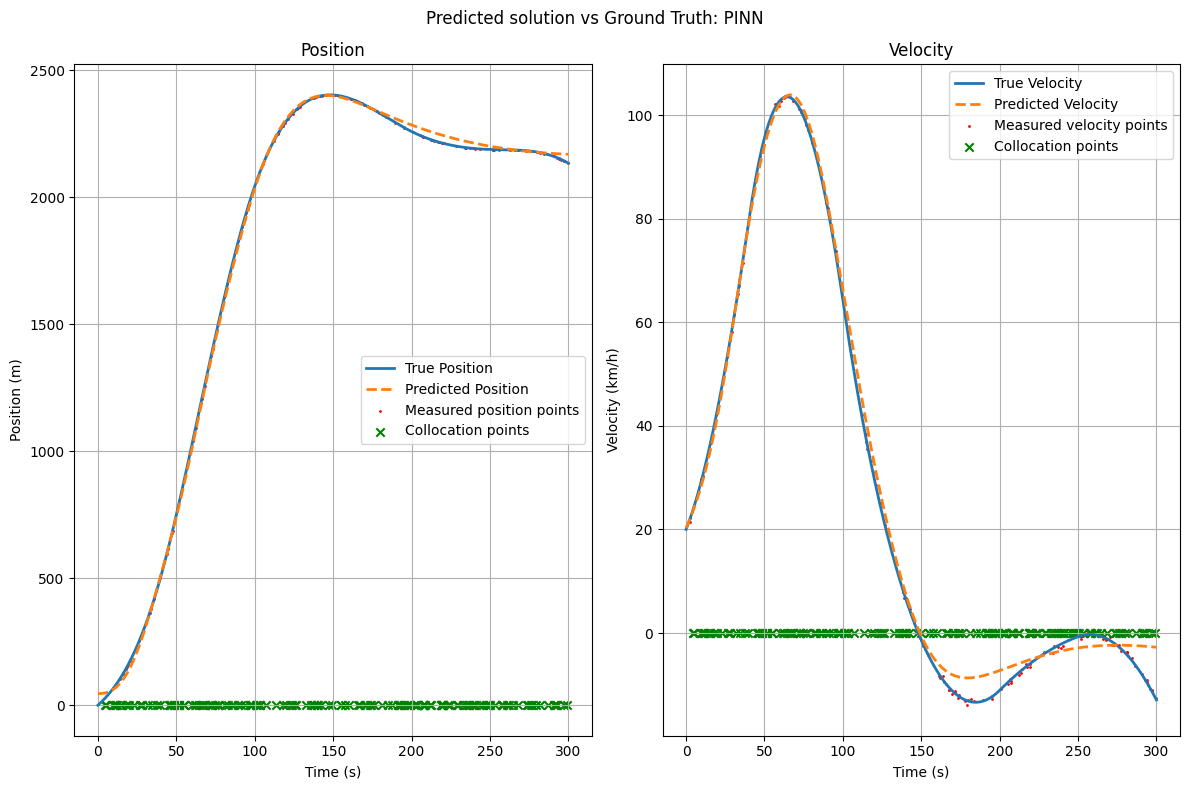

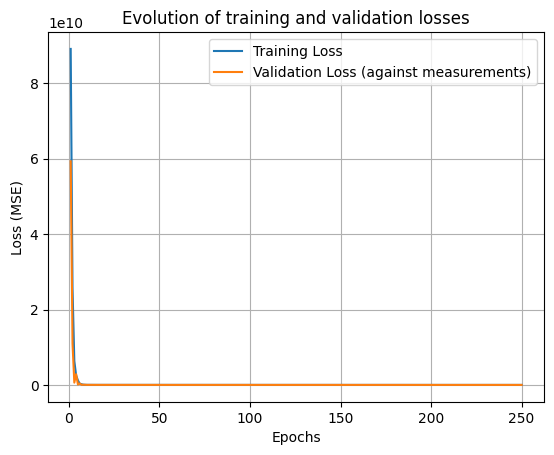

In [153]:
#pinn_model = load_model("pinn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
predictions_norm = punn_model.predict(t_norm)   #predictions shape will be (3000, 2)
predictions = predictions_norm * std_X_train + mean_X_train 

comparison_plot(t, X_true, X_mask, predictions, collocation_pts=t_c, suptitle="Predicted solution vs Ground Truth: PINN")
loss_plot(history_pinn_fwd.history, epochs)
